In [29]:
import re
import json
import random
import numpy as np
import pandas as pd 
from glob import glob

from textwrap import wrap
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

from pymagnitude import *
from tqdm import tqdm 

%matplotlib inline
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

def grey_color_func(**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

## plot settings

In [2]:
rcParams['figure.figsize'] = 20, 8
plt.rcParams.update({'font.size': 24})
plt.style.use('seaborn-ticks')

In [3]:
with open('../generated_material/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)
    
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']
conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

## Load the representative Articles of each Community and append limited amount of them to the Dataframe

In [4]:
repr_files = glob("../representatives/firstRun/*.csv")

repr_articles_df = pd.DataFrame()

max_articles_perCom = 900
for repr_file in repr_files:
    repr_df = pd.read_csv(repr_file)
    repr_articles_df = repr_articles_df.append(repr_df[:max_articles_perCom])

In [5]:
repr_articles_df.head(5)

ID_Article  communityId  ID_RelatedVenue  \
0      984799        13990             8839   
1     2066865        13990            22021   
2     2228102        13990            20561   
3     1972033        13990            11321   
4     1999607        13990            22021   

                                               title  year  \
0        From grad school, to startup to acquisition  2014   
1  Sneak-path constraints in memristor crossbar a...  2013   
2  Developing a Critical Infrastructure and Contr...  2013   
3  Information-theoretic connectivity-based corte...  2011   
4  Global estimation of anatomical connection str...  2011   

                                            abstract  
0  In 2006, John Bicket and Sanjit Biswas took a ...  
1  In a memristor crossbar array, a memristor is ...  
2  This paper discusses the initial course develo...  
3  One of the most promising avenues for compilin...  
4  This paper addresses an important problem in d...

In [6]:
repr_articles_df['communityId'].value_counts()

13990    900
14010    900
14018    900
14040    900
14125    900
14133    900
15226    900
15237    900
15258    900
15514    900
15517    900
14127    882
15510    751
Name: communityId, dtype: int64

## No. of representative Articles published per Year (all communities combined)
to see which years account for majority of the years presented in

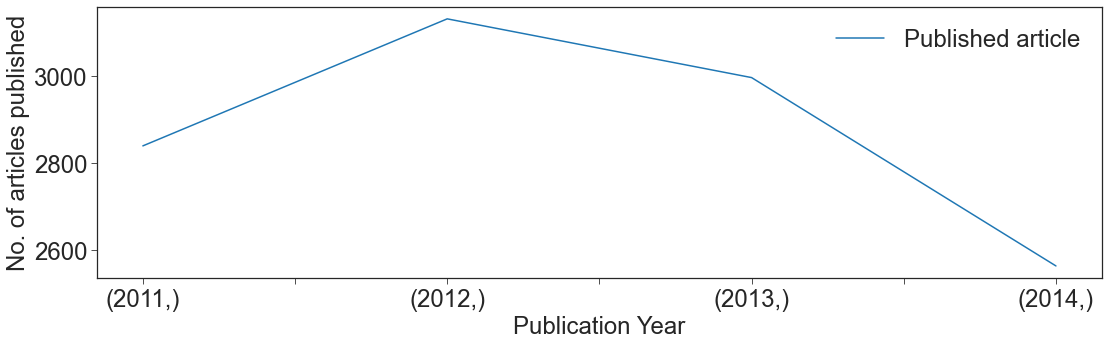

In [7]:
ax = repr_articles_df[['year']].sort_values(by='year').value_counts(sort=False).plot(figsize=(18,5))
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of articles published')
# plt.title('Distribution of articles against the year it was presented in')
plt.legend(["Published article"])
plt.show()

## No. of Articles per year for each Community

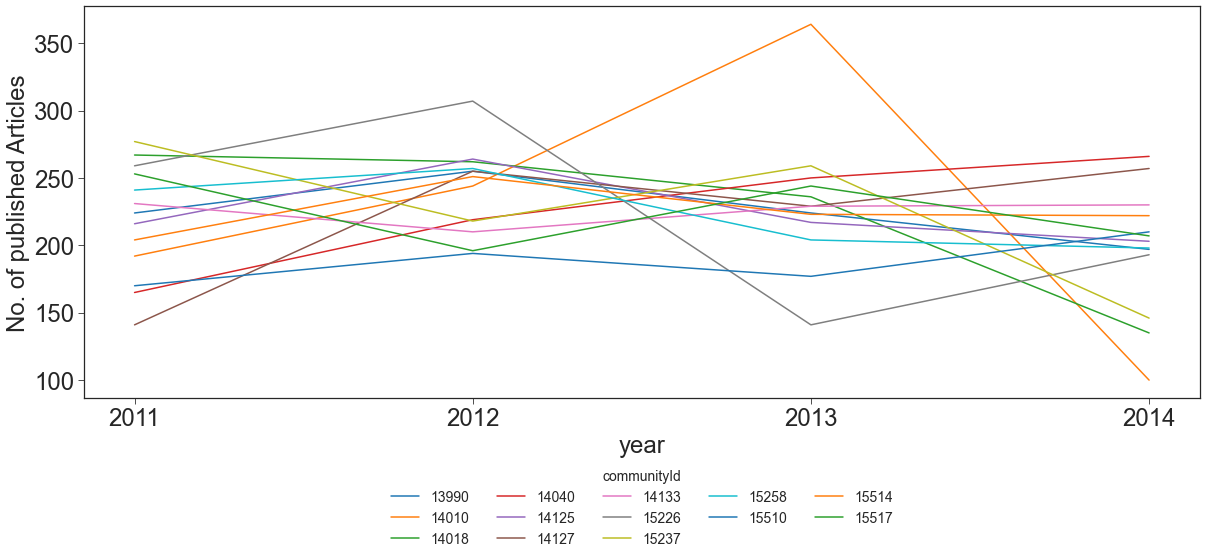

In [8]:
ax = plt.subplot(111)
plt.rcParams.update({'font.size': 14})
rcParams['figure.figsize'] = 18,8
for comm in repr_articles_df.communityId.unique():
    to_plot = repr_articles_df[(repr_articles_df['communityId'] == comm) & (repr_articles_df['year'] >= 1990) & (repr_articles_df['year'] <= 2015)].sort_values(by='year')['year'].value_counts(sort=False)
    years = to_plot.index
    counts = to_plot.values
    plt.plot(years, counts, label = comm)
# plt.title('Distribution of articles of the different communities against the year it was presented in')
plt.xticks([2011, 2012, 2013, 2014])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Putting a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, title="communityId")
plt.xlabel("year")
plt.ylabel("No. of published Articles")
plt.show()

### List the conference names for each venue Id

In [9]:
confs = repr_articles_df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)['ID_RelatedVenue'].unique()

for conf in confs:
    print(f"{conf}: {conference_data_dict[conf]}")

8839: acm ieee international conference on mobile computing and networking
22021: international symposium on information theory
20561: hawaii international conference on system sciences
11321: international conference on machine learning
20348: information processing in sensor networks
10192: international conference on computer communications and networks
208: mobile adhoc and sensor systems
9015: international conference on embedded networked sensor systems
30: international conference of the ieee engineering in medicine and biology society
293: passive and active network measurement
8228: international conference on communications
10228: wireless communications and networking conference
369: vehicular technology conference
22164: conference on information sciences and systems
8494: international symposium on circuits and systems
23922: computational learning theory
20332: national conference on artificial intelligence
9969: international cryptology conference
22288: international co

### Dict with the original Venue Abbreviations 

In [18]:
confs = repr_articles_df.groupby('ID_RelatedVenue').filter(lambda x: len(x) > 20)['ID_RelatedVenue'].unique()
confs

conf_abbvs = dict()

for conf in confs:
    conf_abbvs[conf] = ''.join([s[0].upper() for s in conference_data_dict[conf].split()])

### Show for each venue how many articles per community were published and use the venue Ids with the Abbreviations

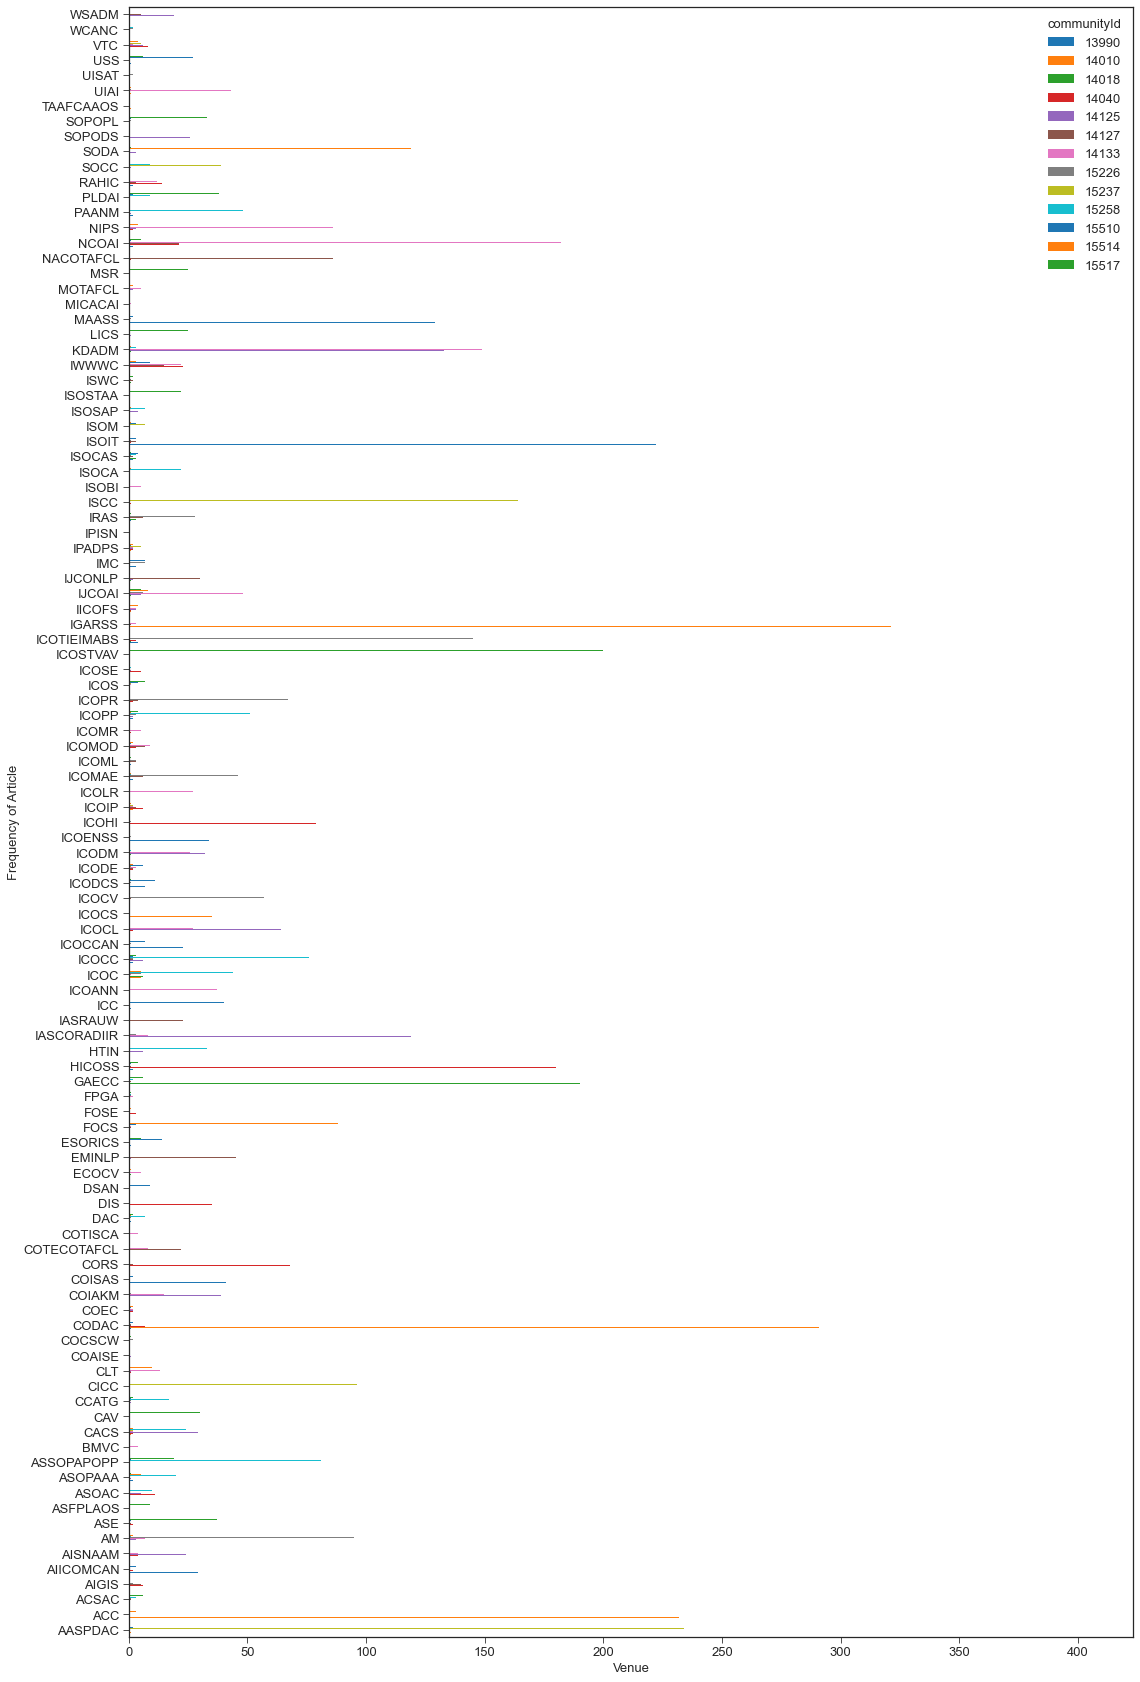

In [21]:
plt.rcParams.update({'font.size': 13})
rcParams['figure.figsize'] = 18,30

plot_df = repr_articles_df.groupby("ID_RelatedVenue").filter(lambda x: len(x) > 20)
plot_df['ID_RelatedVenue'] = plot_df['ID_RelatedVenue'].apply(lambda x: conf_abbvs[x])
results = pd.crosstab(plot_df['ID_RelatedVenue'], plot_df['communityId'])
results.plot.barh()
plt.xlabel("Venue")
plt.ylabel("Frequency of Article")
plt.show()

Um die Artikel Communityübergreifend zu analysieren, werden jetzt nur die Titel der Artikel genutzt. Könnte auch die Abstracts nehmen, aber das macht ja nicht so einen großen Unterschied, wie man in den einzelnen Analysen auch schon gesehen hat. Spart Memory und machts auch einfacher.

In [22]:
titles_df = pd.DataFrame()
stop_words.update(['based', 'using', 'A', 'The', 'system', 'algorithm'])

titles_df['processed_words'] = repr_articles_df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: row['processed_words'].lower(), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: (word_tokenize(row['processed_words'])), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([w for w in row['processed_words'] if w not in stop_words]), axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['processed_words']]), axis=1)
titles_df['concatenated_words'] = titles_df.apply(lambda row: ' '.join(row['processed_words']), axis=1)
titles_df['communityId'] = repr_articles_df['communityId']
titles_df['ID_Article'] = repr_articles_df['ID_Article']

### Top 15 Words Distribution across Communities

Plotting der 15 meist verwendeten Wörter und die dazugehörige Verteilung.
Jedes Wort bekommte eine bar und die Verteilung über die Communities für dieses Wort wird gefärbt für jede einzelne Community

In [23]:
top_15_words = pd.Series(' '.join(titles_df['concatenated_words']).split()).value_counts()[:15].index.to_list()

community_word_freqs = list()
for word in top_15_words:
    word_freq_list = list()
    for communityId in titles_df['communityId'].unique():
        df_ = titles_df[titles_df['communityId'] == communityId]
        word_freq_list.append(df_.concatenated_words.str.count(word).sum())
    community_word_freqs.append(word_freq_list)
    
df_list, cols = list(), list()

for word, counts in zip(top_15_words, community_word_freqs):
    df_list.append([word] + counts)

cols = ['Word'] + [community for community in titles_df['communityId'].unique()]

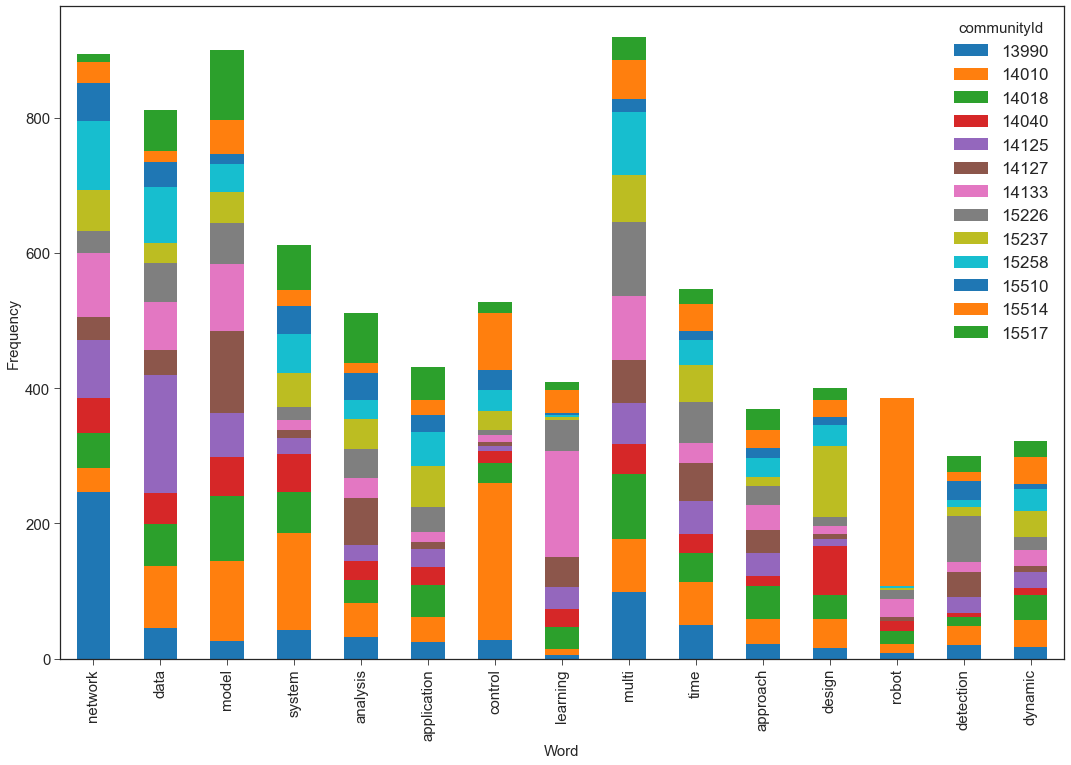

In [24]:
rcParams['figure.figsize'] = 18,12
plt.rcParams.update({'font.size': 15})
freq_df = pd.DataFrame(df_list, columns=cols)
freq_df.plot(x='Word',kind='bar', stacked=True)
plt.legend(title="communityId", fontsize=17)
plt.ylabel("Frequency")
plt.show()

## Wordcloud Visualization

Wordcloud for each community to see which are the most common terms and words that appear in the titles of the articles. 
To get an idea of what the topics of the community are.

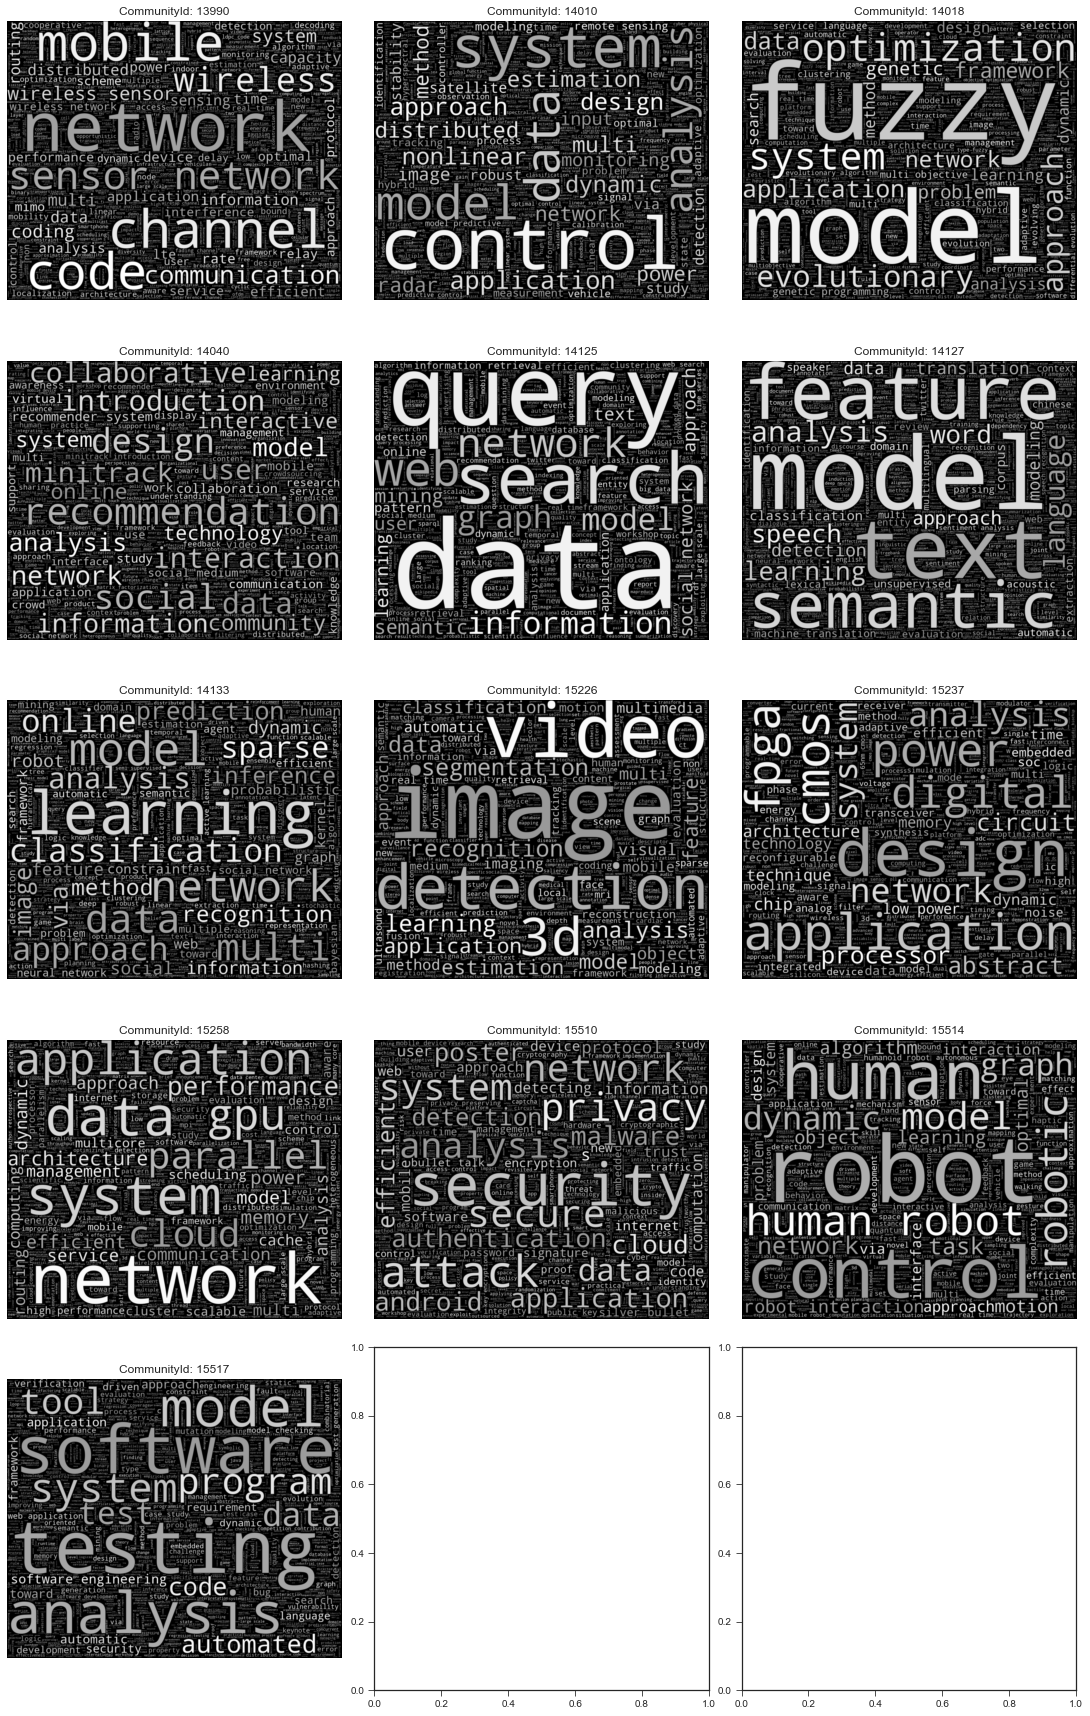

In [30]:
figure, axis = plt.subplots(5,3, figsize=(15,24))
# Function for generating word clouds
def generate_wordcloud(data, communityId, x,y):
    wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words.update([]), width=1200, height=1000)
    wc.generate(" ".join(data))
    wc.recolor(color_func=grey_color_func, random_state=17)
    # axis[y,x].figure(figsize=(15,8))
    axis[y,x].imshow(wc, interpolation='bilinear')
    axis[y,x].axis("off")
    axis[y,x].title.set_text('\n'.join(wrap('CommunityId: ' + str(communityId),60)))

# Plotting word cloud for each communityId
for i,communityId in enumerate(plot_df['communityId'].unique()):
    word_data = titles_df[titles_df['communityId'] == communityId]['concatenated_words'].values
    generate_wordcloud(word_data, communityId, i%3, int(i/3))
plt.tight_layout(pad=0.2)

## Visualizing titles of the articles onto 2D Space through t-SNE

1. FastText Embedding der Title
2. pyMagnitude für vektorisierung der Daten (jedes Word wird gewichtet nach dem entsprechenden Durchschnitt. Insgesammt entsteht ein 300-D Vektor)
Gewichtungen mithilfe der Inverse Document Frequency (IDF) (Anzahl aller Dokumente) / (Anzahl der Dokumente, die das Wort beinhalten)
1. Reduktion der Dimensionen auf 2D mithilfe von t-SNE


In [31]:
# Magnitude File: http://magnitude.plasticity.ai/fasttext/medium/wiki-news-300d-1M-subword.magnitude
fasttext = Magnitude("vectors/wiki-news-300d-1M-subword.magnitude")

### Inverse Document Frequency Vectors for each community (idf score assignment to each word)

In [32]:
idf_dicts = dict()

for comm in titles_df['communityId'].unique():
    tfidf = TfidfVectorizer()
    tfidf.fit(titles_df[titles_df['communityId'] == comm]['concatenated_words'].values)
    idf_dicts[comm] = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

### Every article title gets a vector based of the average of the specific word vectors (weighted by the idf scores)

In [33]:
def idf_fasttext(df):
    vectors = []
    for title, comm in tqdm(zip(df.title.values, df.communityId.values)):
        fasttext_vectors = fasttext.query(word_tokenize(title))
        weights = [idf_dicts[comm].get(word, 1) for word in word_tokenize(title)]
        vectors.append(np.average(fasttext_vectors, axis = 0, weights = weights))
    return np.array(vectors)

vectors = idf_fasttext(repr_articles_df)

11533it [03:37, 53.06it/s]


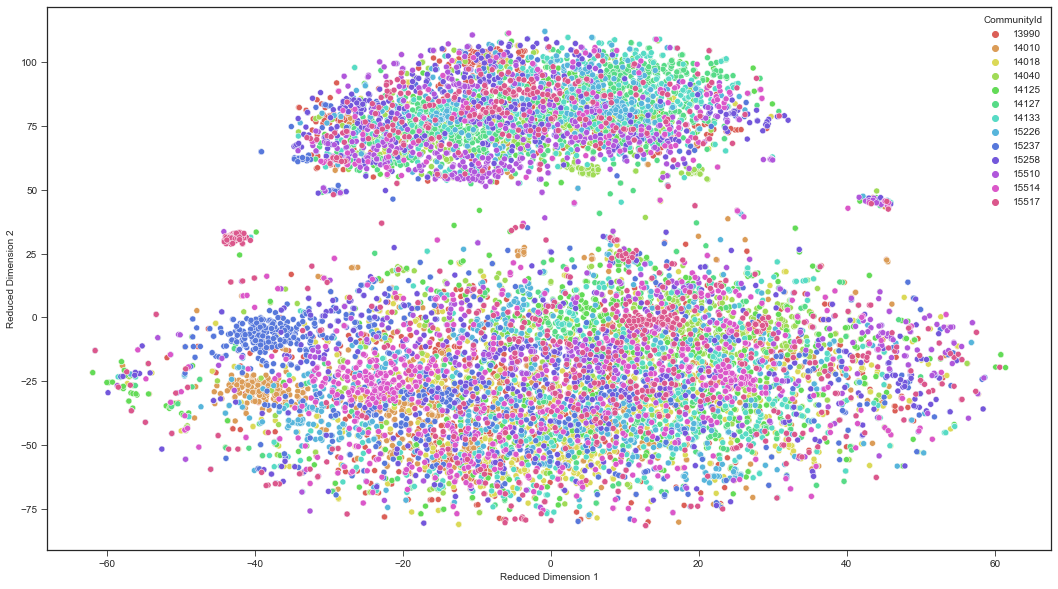

In [34]:
rcParams['figure.figsize'] = 18, 10
tsne = TSNE(n_components = 2, n_jobs= -1, verbose = 0, perplexity = 50, n_iter=2500)
tsne_data = tsne.fit_transform(vectors)

tsne_data = pd.DataFrame(tsne_data, columns = ['Reduced Dimension 1', 'Reduced Dimension 2'])
tsne_data['CommunityId'] = titles_df['communityId'].values

sns.scatterplot(x = 'Reduced Dimension 1', y = 'Reduced Dimension 2', hue='CommunityId', palette=sns.color_palette("hls", 13), data = tsne_data)
# plt.title('TSNE on IDF-Fasttext Title Embeddings')

plt.show()

Die Title Embeddings variieren über den ganzen 2D Raum. Aber man sieht, dass die einzelnen communities an manchen Stellen auch eng aneinander sind. 20178 ist auffällig seperiert von den anderen Gruppen (wäre interessant, das weiter zu investigieren).
Es kristallisieren sich aus dieser Perspektive drei übergeordnete Gruppierungen. Einne sehr große oben, eine mittlere unten und die 20178 Gruppe. Was haben diese Gruppierungen gemeinsam? Sind diese vielleicht auch in ähnliche Themengebiete einteilbar?

Als nächstes noch die Visualisierung in 3 Dimensionen

In [35]:
tsne_3d = TSNE(n_components = 3, n_jobs= -1, verbose = 0, perplexity = 100, n_iter=5000)
tsne_data_3d = tsne_3d.fit_transform(vectors)

tsne_data_3d = pd.DataFrame(tsne_data_3d, columns = ['Reduced Dimension 1', 'Reduced Dimension 2', 'Reduced Dimension 3'])
tsne_data_3d['communityId'] = titles_df['communityId'].values
tsne_data_3d['communityId'] = tsne_data_3d['communityId'].astype('str')
tsne_data_3d = tsne_data_3d.drop([5951], axis='index') # Removing an outlier which affects the visualization of the plot


In [36]:
fig = px.scatter_3d(tsne_data_3d, x='Reduced Dimension 1', y='Reduced Dimension 2', z='Reduced Dimension 3', color='communityId', 
                    color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
)
fig.update_traces(marker={'size': 4})

fig.show()

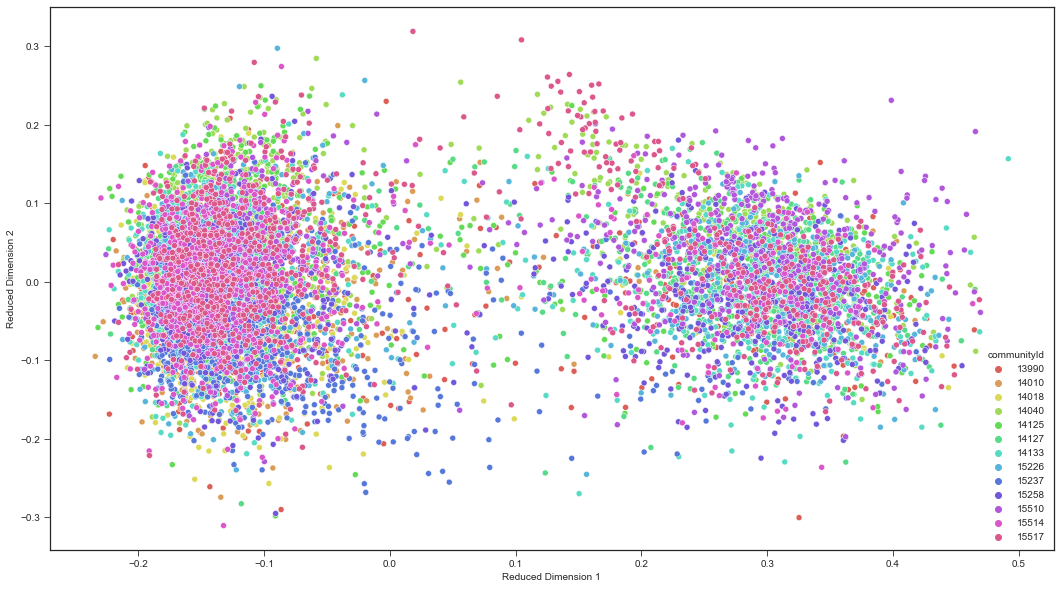

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(vectors)

pca_data = pd.DataFrame(pca_data, columns = ['Reduced Dimension 1', 'Reduced Dimension 2'])
pca_data['communityId'] = titles_df['communityId'].values

sns.scatterplot(x = 'Reduced Dimension 1', y = 'Reduced Dimension 2', hue='communityId', palette=sns.color_palette("hls", 13), data = pca_data)

plt.show()

In [39]:
pca_3d = PCA(n_components = 3)
pca_data_3d = pca_3d.fit_transform(vectors)

pca_data_3d = pd.DataFrame(pca_data_3d, columns = ['Reduced Dimension 1', 'Reduced Dimension 2', 'Reduced Dimension 3'])
pca_data_3d['communityId'] = titles_df['communityId'].values
pca_data_3d['communityId'] = pca_data_3d['communityId'].astype('str')
pca_data_3d = pca_data_3d.drop([5951], axis='index') # Removing an outlier which affects the visualization of the plot

In [41]:
fig = px.scatter_3d(pca_data_3d, x='Reduced Dimension 1', y='Reduced Dimension 2', z='Reduced Dimension 3', color='communityId', 
                    color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
)
fig.update_traces(marker={'size': 4})

fig.show()